In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import joblib
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20})

In [3]:
X_train = pd.read_pickle("/Users/ilseeb/Desktop/Postgraduate/Train Punctuality Data/train_test_data/X_train_processed.pkl")
y_train = pd.read_pickle("/Users/ilseeb/Desktop/Postgraduate/Train Punctuality Data/train_test_data/y_train_over.pkl")

In [4]:
X_train.drop(columns=["date"], inplace=True)

In [4]:
clf = LogisticRegression(solver='sag', random_state=0)

In [7]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve All variables')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

In [8]:
def compute_roc_auc(index):
    y_predict_prob = clf.predict_proba(X_train.iloc[index])[:,1]
    y_predict = clf.predict(X_train.iloc[index])
    fpr, tpr, thresholds = roc_curve(y_train.iloc[index], y_predict_prob)
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_train.iloc[index], y_predict)
    precision = precision_score(y_train.iloc[index], y_predict)
    recall = recall_score(y_train.iloc[index], y_predict)
    return fpr, tpr, auc_score, accuracy, precision, recall

In [9]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

In [9]:
for (train, test), i in zip(cv.split(X_train, y_train), range(5)):
    clf.fit(X_train.iloc[train], y_train.iloc[train])
    _, _, auc_score_train, accuracy_train, precision_train, recall_train = compute_roc_auc(train)
    fpr, tpr, auc_score, accuracy, precision, recall = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score, accuracy_train, accuracy
                   ,precision_train, precision, recall_train, recall))
    fprs.append(fpr)
    tprs.append(tpr)

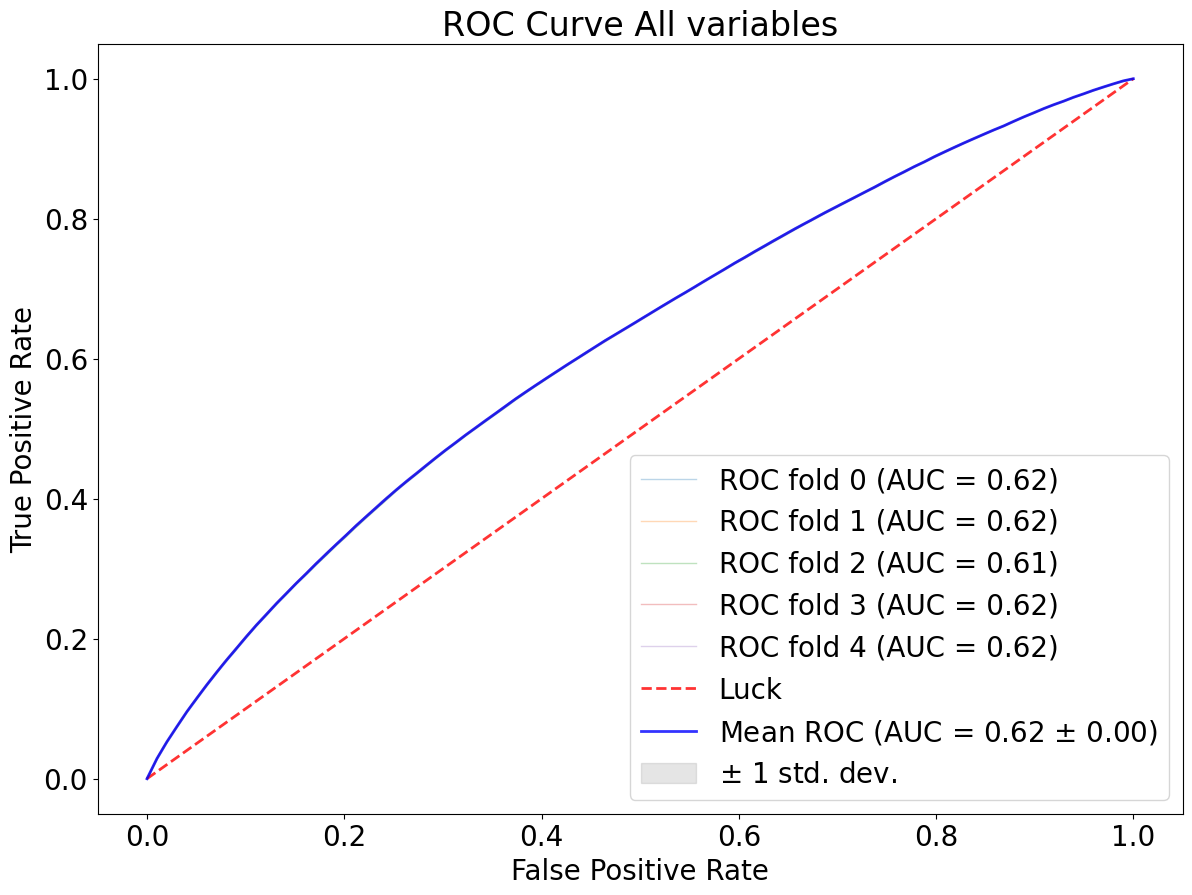

,AUC Train,AUC Test,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test
0,0.615589,0.615803,0.582827,0.582811,0.581872,0.581832,0.588661,0.588789
1,0.615651,0.615694,0.582848,0.582654,0.581760,0.581462,0.589499,0.589963
2,0.615833,0.614889,0.582916,0.582390,0.581823,0.581419,0.589592,0.588354
3,0.615603,0.615823,0.582737,0.583110,0.581662,0.582214,0.589317,0.588562
4,0.615585,0.615924,0.582784,0.583286,0.581707,0.582023,0.589377,0.590987


In [10]:
plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'
                              , 'Accuracy Train', 'Accuracy Test'
                              ,'Precision Train', 'Precision Test'
                              ,'Recall Train', 'Recall Test'])

In [11]:
clf.classes_

array([False,  True])

In [5]:
clf = LogisticRegression(solver='liblinear', random_state=0)

In [10]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X_train, y_train), range(5)):
    clf.fit(X_train.iloc[train], y_train.iloc[train])
    _, _, auc_score_train, accuracy_train, precision_train, recall_train = compute_roc_auc(train)
    fpr, tpr, auc_score, accuracy, precision, recall = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score, accuracy_train, accuracy
                   ,precision_train, precision, recall_train, recall))
    fprs.append(fpr)
    tprs.append(tpr)

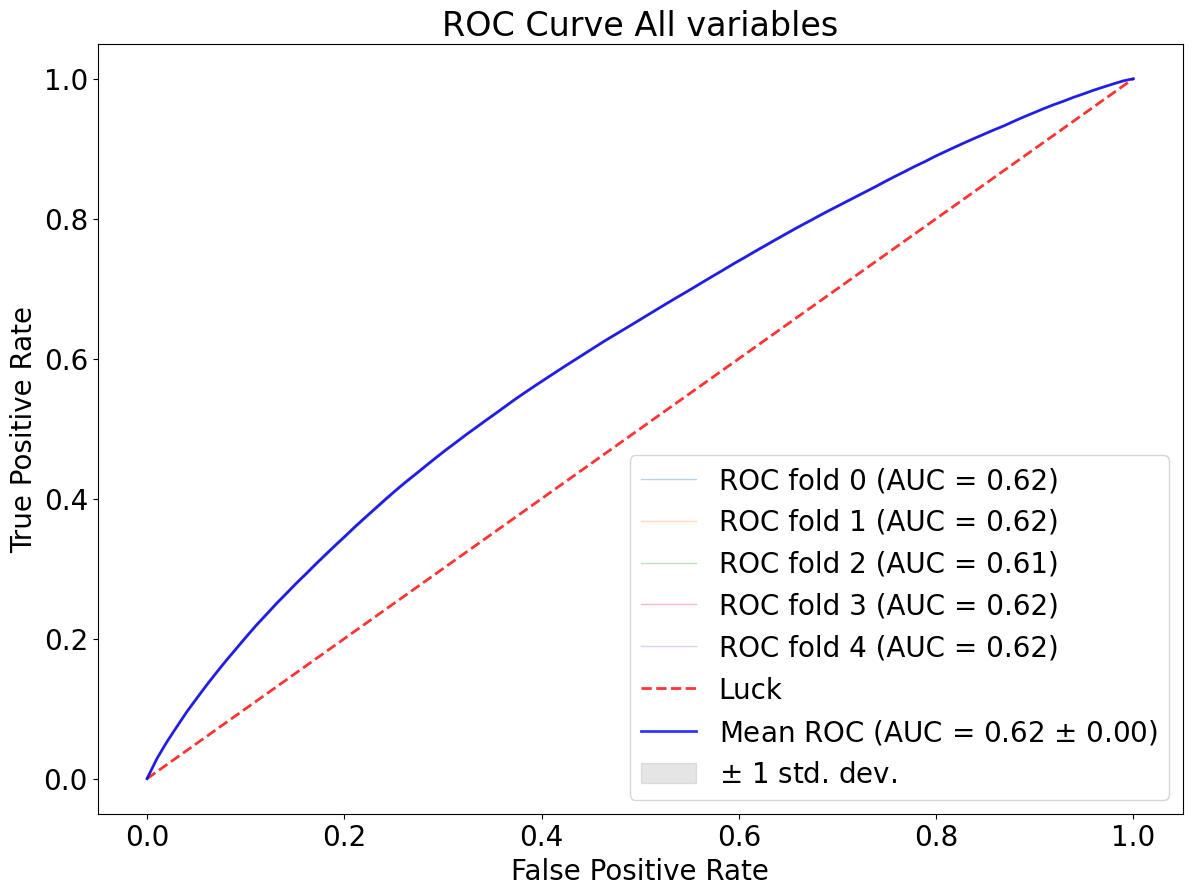

,AUC Train,AUC Test,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test
0,0.615589,0.615803,0.582843,0.582824,0.581902,0.581859,0.588592,0.588716
1,0.615649,0.615689,0.582844,0.582648,0.581756,0.581457,0.589499,0.589953
2,0.615834,0.614889,0.582900,0.582380,0.581803,0.581406,0.589601,0.588363
3,0.615603,0.615823,0.582732,0.583111,0.581651,0.582210,0.589353,0.588596
4,0.615585,0.615924,0.582775,0.583272,0.581707,0.582017,0.589310,0.590924


In [11]:
plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'
                              , 'Accuracy Train', 'Accuracy Test'
                              ,'Precision Train', 'Precision Test'
                              ,'Recall Train', 'Recall Test'])

In [12]:
# feature selection
X_train_fs = X_train[['relative_humidity',
       'month_APR', 'month_AUG', 'month_DEC', 'month_FEB', 'month_JAN',
       'month_JUL', 'month_JUN', 'month_MAR', 'month_MAY', 'month_NOV',
       'month_OCT', 'month_SEP', 'destination_region_BRUSSELS-CAPITAL REGION',
       'destination_region_FLANDERS', 'destination_region_WALLONIA',
       'departure_region_BRUSSELS-CAPITAL REGION', 'departure_region_FLANDERS',
       'departure_region_WALLONIA']]

In [13]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X_train, y_train), range(5)):
    clf.fit(X_train.iloc[train], y_train.iloc[train])
    _, _, auc_score_train, accuracy_train, precision_train, recall_train = compute_roc_auc(train)
    fpr, tpr, auc_score, accuracy, precision, recall = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score, accuracy_train, accuracy
                   ,precision_train, precision, recall_train, recall))
    fprs.append(fpr)
    tprs.append(tpr)

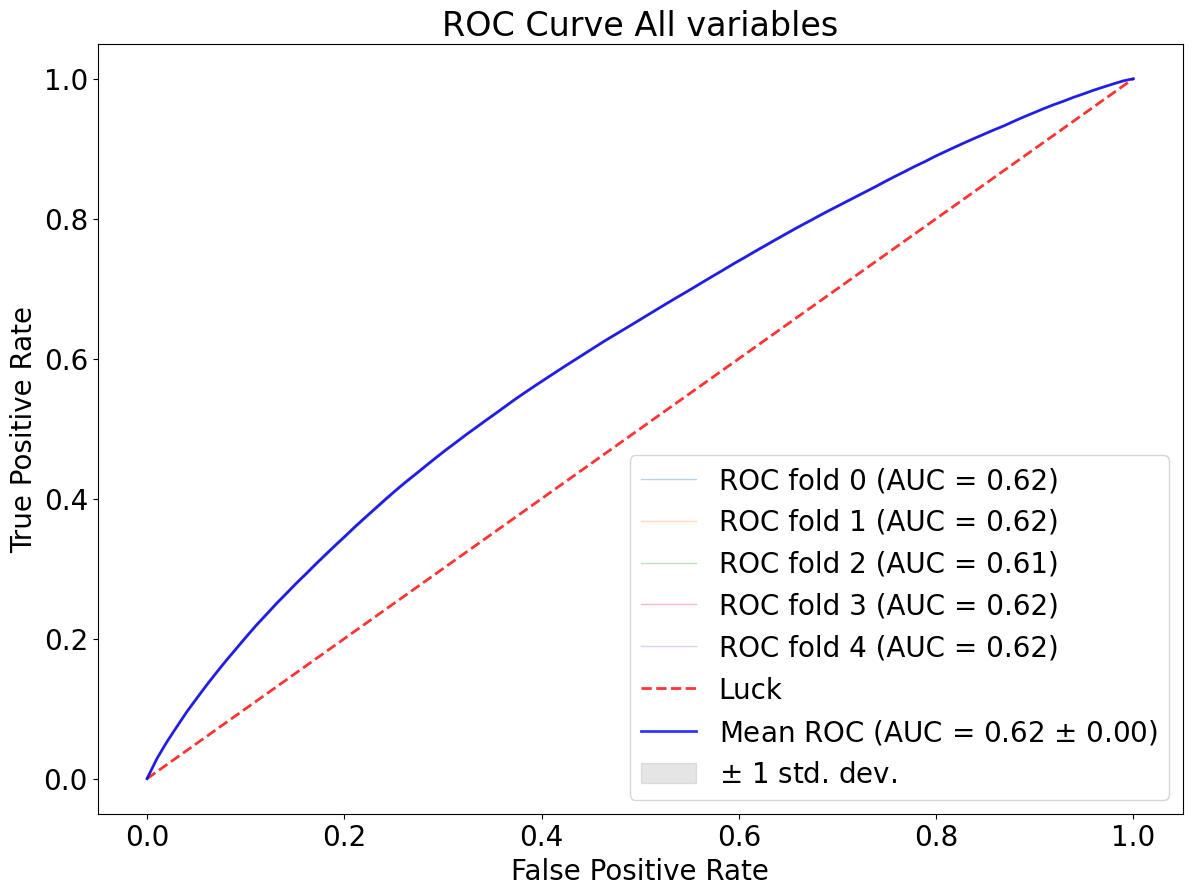

,AUC Train,AUC Test,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test
0,0.615589,0.615803,0.582843,0.582824,0.581902,0.581859,0.588592,0.588716
1,0.615649,0.615689,0.582844,0.582648,0.581756,0.581457,0.589499,0.589953
2,0.615834,0.614889,0.582900,0.582380,0.581803,0.581406,0.589601,0.588363
3,0.615603,0.615823,0.582732,0.583111,0.581651,0.582210,0.589353,0.588596
4,0.615585,0.615924,0.582775,0.583272,0.581707,0.582017,0.589310,0.590924


In [14]:
plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'
                              , 'Accuracy Train', 'Accuracy Test'
                              ,'Precision Train', 'Precision Test'
                              ,'Recall Train', 'Recall Test'])